# What's wrong with sum of squares for logistic regression?

In [1]:
import numpy as np
import pandas as pd
# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt
# Make the plots look more fancy.
plt.style.use('fivethirtyeight')
# Optimization function
from scipy.optimize import minimize

This page gives some extra explanation for the
[logistic_regression](logistic_regression) page.

Here we say more about why we might prefer the Maximum Likelihood Estimate way
of scoring potential fits to the data, to our more usual least squared error.
If you want the gory details on this choice, see [this answer on
StackOverflow](https://stats.stackexchange.com/a/254067). Here we look at
whether this the sum of squares works well with `minimize`.  The discussion in
this page corresponds to the "computational efficiency" section of the answer
linked above.

## The background, the data

In that page we were trying to looking at the [chronic kidney disease
dataset](../data/chronic_kidney_disease), to see if we good predict whether a
patient had "good" appetite (as opposed to "poor" appetite) given that patient's blood hemoglobin concentration.

In [2]:
df = pd.read_csv('ckd_clean.csv')
# Our columns of interest.
hgb_app = df.loc[:, ['Hemoglobin', 'Appetite']].copy()
# Dummy value column containing 0 for "poor" Appetite, 1 for "good".
hgb_app['appetite_dummy'] = hgb_app['Appetite'].replace(
    ['poor', 'good'],
    [0, 1])
hgb_app.head()

,Hemoglobin,Appetite,appetite_dummy
0,11.2,poor,0
1,9.5,poor,0
2,10.8,poor,0
3,5.6,poor,0
4,7.7,poor,0


We take out the columns we are interested in for our further use:

In [3]:
# The x (predictor) and y (to-be-predicted) variables.
hemoglobin = hgb_app['Hemoglobin']
appetite_d = hgb_app['appetite_dummy']

Here is a plot of the 0 / 1 appetite values

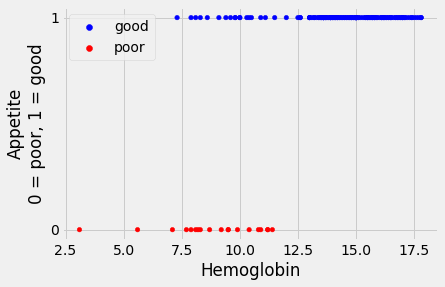

In [4]:
def plot_hgb_app():
    # Build plot, add custom label.
    colors = hgb_app['Appetite'].replace(['poor', 'good'], ['red', 'blue'])
    hgb_app.plot.scatter('Hemoglobin', 'appetite_dummy', c=colors)
    plt.ylabel('Appetite\n0 = poor, 1 = good')
    plt.yticks([0,1]);  # Just label 0 and 1 on the y axis.
    # Put a custom legend on the plot.  This code is a little obscure.
    plt.scatter([], [], c='blue', label='good')
    plt.scatter([], [], c='red', label='poor')

plot_hgb_app()
plt.legend();

## Linear regression - the crude approach

The crude and brutal approach to predicting these values is to use simple
least-squares regression.   We can do this in the usual way by using
`scipy.optimize.minimize` with a function that returns the sum of squared
error between the straight line predictions and the 0 / 1 labels.  Here's the function:

In [5]:
def ss_cost(c_s, x_values, y_values):
    """ Cost function for sum of squares prediction error
    """
    # c_s is a list containing two elements, an intercept and a slope.
    intercept, slope = c_s
    # Values predicted from these x_values, using this intercept and slope.
    predicted = intercept + x_values * slope
    # Difference of prediction from the actual y values.
    error = y_values - predicted
    # Sum of squared error.
    return np.sum(error ** 2)

Start with a guess of intercept -0.5, slope 0.1:

In [6]:
# Use cost function with miminize.
mr_ss = minimize(ss_cost, [-0.5, 0.1], args=(hemoglobin, appetite_d))
mr_ss

      fun: 10.3155095224358
 hess_inv: array([[ 0.07498683, -0.00524735],
       [-0.00524735,  0.00038337]])
      jac: array([-1.19209290e-07,  2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([-0.07904106,  0.07004924])

Store the slope and intercept, predict the values directly from the straight line:

In [7]:
inter_ss, slope_ss = mr_ss.x
predicted_ss = inter_ss + slope_ss * hemoglobin

Show the results:

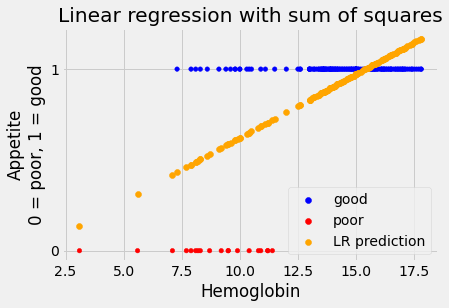

In [8]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predicted_ss,
            label='LR prediction',
            color='orange')
plt.title("Linear regression with sum of squares")
# Show the legend.
plt.legend();

Let us remind ourselves of how the sum of squared error values change as we change the slope and the intercept.  First we hold the slope constant at a fairly bad guess of 0.1, and try different intercepts.  For each intercept we calculate the sum of squared error:

Text(0.5, 1.0, 'Errors for different intercepts, slope 0.1')

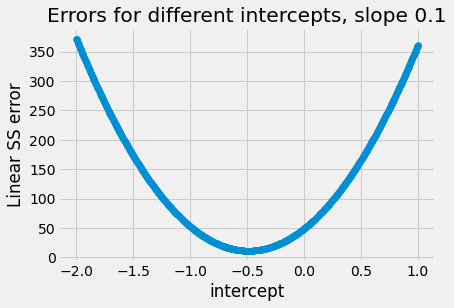

In [9]:
# Some intercepts to try.
intercepts = np.linspace(-2, 1, 1000)
n_inters = len(intercepts)
ss_errors = np.zeros(n_inters)
for i in np.arange(n_inters):
    ss_errors[i] = ss_cost([intercepts[i], 0.1], hemoglobin, appetite_d)
plt.scatter(intercepts, ss_errors)
plt.xlabel('intercept')
plt.ylabel('Linear SS error')
plt.title("Errors for different intercepts, slope 0.1")

Notice the very simple shape of this curve.  It is a parabola, it descends
steeply for values far from the minimum, and more slowly as it gets closer.
This is a curve that `minimize` finds it very easy to work with, because every
time it tries an intercept (in this case), the direction (up, down) of the
curve tells `minimize` what direction to go next.  If the curve is going down
at this point, it should try a larger (more positive) intercept value; if the
curve is going up, it should try a smaller (more negative) intercept. The
up/down-ness of the curve tells `minimize` the right way to go, and this
direction is always correct.  You may also have noticed that this parabola
shape is always the same for these simple least squares functions, like
`ss_any_line`.

Just to illustrate again, here we try holding the intercept constant at a fairly bad guess of 0.5, and vary the slopes.  Notice we get the same helpful parabola shape:

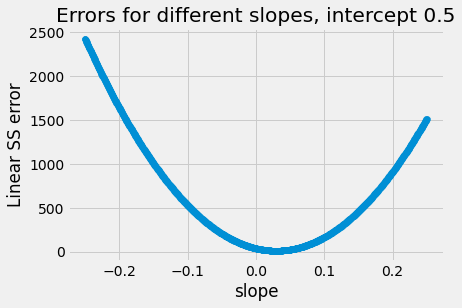

In [10]:
# Slopes to try.
slopes = np.linspace(-0.25, 0.25, 1000)
n_slopes = len(slopes)
ss_errors = np.zeros(n_slopes)
for i in np.arange(n_slopes):
    ss_errors[i] = ss_cost([0.5, slopes[i]], hemoglobin, appetite_d)
plt.scatter(slopes, ss_errors)
plt.xlabel('slope')
plt.ylabel('Linear SS error')
plt.title("Errors for different slopes, intercept 0.5");

These are plots of how the value of the *cost function* changes as we change
the parameters.  The parabolas we see above are examples of curves that are
[convex](https://en.wikipedia.org/wiki/Convex_function); convex curves like
parabolas are particularly easy and quick for `minimize` to work with.

We will see that using sum of squared error with our preferred sigmoid
prediction generates cost function curves that are a lot more complicated,
making it more difficult for `minimize` to find the best parameters.  If we
give `minimize` a bad initial guess, it can get the answer badly wrong. Put
technically, this is because the cost function curves are not convex.

## Sigmoid prediction with sum of squares error

For the reasons you saw in the [logistic regression page](logistic
regression), we recoil from the very simple straight line fit above, and
prefer to use a sigmoid curve to fit the 0 / 1 labels.

In that page we defined the functions to convert the straight line predictions
that we want to use with `minimize` and the sigmoid predictions:

In [11]:
def inv_logit(y):
    """ Reverse logit transformation
    """
    odds_ratios = np.exp(y)  # Reverse the log operation.
    return odds_ratios / (odds_ratios + 1)  # Reverse odds ratios operation.


def params2pps(intercept, slope, x):
    """ Calculate predicted probabilities of 1 for each observation.
    """
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    return inv_logit(predicted_log_odds)

This allowed us to build our sum of squares logit cost function.  This
function calculates the sum of squares difference from the sigmoid predictions
and the actual 0 / 1 labels.

In [12]:
def ss_logit_cost(c_s, x_values, y_values):
    # Unpack intercept and slope into values.
    intercept, slope = c_s
    # Predicted p values on sigmoid
    pps = params2pps(intercept, slope, x_values)
    # Prediction errors.
    sigmoid_error = y_values - pps
    # Sum of squared error
    return np.sum(sigmoid_error ** 2)

Then we found our sum of squares best straight line (that corresponds to a
sigmoid after transformation).  Notice that we have started `minimize` with a
guessed intercept of -7 and a guessed slope of 0.8.

In [13]:
mr_ss_logit = minimize(ss_logit_cost, [-7, 0.8], args=(hemoglobin, appetite_d))
mr_ss_logit

      fun: 9.621504133676222
 hess_inv: array([[ 6.0509272 , -0.57246015],
       [-0.57246015,  0.05674741]])
      jac: array([-1.19209290e-07,  2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([-5.28090451,  0.58493981])

We can calculate the predicted 0 / 1 labels, and plot them.

In [14]:
inter_ss_logit, slope_ss_logit = mr_ss_logit.x
predicted_ss_logit = params2pps(inter_ss_logit, slope_ss_logit, hemoglobin)

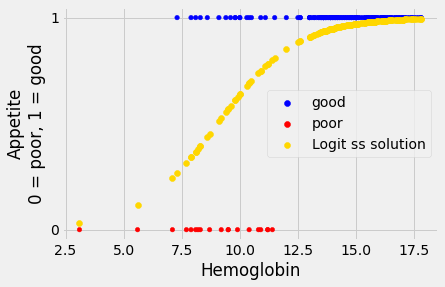

In [15]:
plot_hgb_app()
# A new plot on top of the old.
plt.scatter(hemoglobin, predicted_ss_logit,
            label='Logit ss solution',
            color='gold')
# Show the legend.
plt.legend();

Let us have a look at what the cost function curves look like for the `ss_logit_cost` cost function.  For now, let us look at what happens to the cost function curves as we change the intercept, holding the slope the same.

Because we will do this several times, with various intercepts and constant slopes, we make a function, so we don't repeat ourselves:

In [16]:
def plot_some_intercepts(cost_function, intercepts, slope):
    """ Plot values of `cost_function` for given `intercepts` and `slope`

    Parameters
    ----------
    cost_function : function
        Function to call to get cost function value, given an intercept and a slope.
    intercepts : array
        Array of intercepts for which to calculate cost function.
    slope : number
        Slope (held constant for each intercept).
    """
    n = len(intercepts)
    ss_errors = np.zeros(n)
    for i in np.arange(n):
        # Calculate and store cost function value for intercept, slope.
        ss_errors[i] = cost_function([intercepts[i], slope],
                                     hemoglobin, appetite_d)
    plt.plot(intercepts, ss_errors, linewidth=1)
    plt.xlabel('intercept')
    plt.ylabel('Cost function value');
    plt.title('Errors for slope = %.2f' % slope)

Remember the attractive parabolas for the cost function curves in the crude
case above, where we were doing simple regression.

In the next cell, we set the slope to the best slope that `minimize`
found, and show the effect on our `ss_logit_cost` function, when varying the intercept.

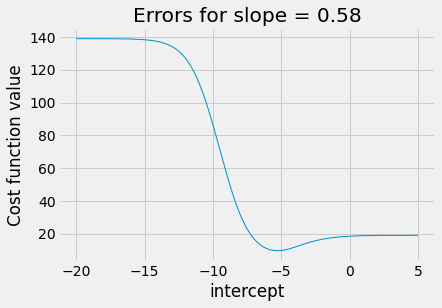

In [17]:
# Cost function curve varying intercept between -20 and 5, for best slope.
plot_some_intercepts(ss_logit_cost, np.linspace(-20, 5, 1000), slope_ss_logit)

There is a clear minimum at around -5.2, as we expect from the results above,
but we have lost the nice parabola shape.  For intercepts greater than about
3, the graph is very flat.  This could spell trouble for `minimize`, if it
gets stuck trying a series of intercepts more than 3.  For example, the cost
function will stay almost the same as `minimize` tries values around 5, so
`minimize` may not discover that it needs to track back to the real minimum,
near -5.

It can get even worse when trying slopes that are further away from the
optimum.  In the next plot, we set the slope badly wrong, at 3, and try different intercepts.

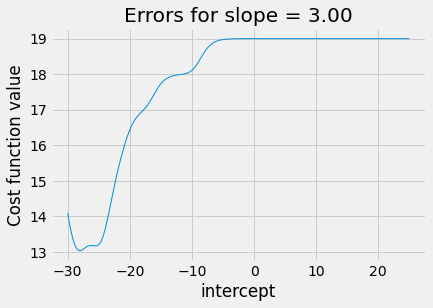

In [18]:
plot_some_intercepts(ss_logit_cost, np.linspace(-30, 25, 1000), 3)

The plot is a strange shape. Again we see a nasty plateau with intercepts
above 0.  If `minimize` is trying intercepts above 0, the cost function may
not vary much, and `minimize` may get stuck on this plateau, for example
concluding the intercept of 6 is as good as any nearby.

An in fact, this does happen if we set very bad starting estimates for
`minimize`.  Here we set the starting intercept to be 6, and the starting
slope to be 2.5.

In [19]:
bad_mr_ss_logit = minimize(ss_logit_cost, [6, 2.5],
                           args=(hemoglobin, appetite_d))
bad_mr_ss_logit

      fun: 18.999997860319507
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([2.14576721e-06, 6.67572021e-06])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([6. , 2.5])

You can see that `minimize` has got stuck on the plateau we saw above and has
given up, simply returning the terrible intercept and slope we sent it.

You can also see that `minimize` did not detect any problems, and returned the
message "Optimization terminated successfully".

We have this problem because of the irregular shape of the cost-function curve for our cost function, that calculates sum of squared error for the sigmoid predictions.

## Back to maximum likelihood

The [logistic_regression](logistic_regression) page proposed an alternative
cost function for the sigmoid predictions - maximum likelihood.  See that page
for details, but here is somewhat cleaned up version the maximum likelihood
cost function from the page above.

In [20]:
def ml_logit_cost(intercept_and_slope, x, y):
    """ Cost function for maximum likelihood
    """
    intercept, slope = intercept_and_slope
    pp1 = params2pps(intercept, slope, x)
    p_of_y = y * pp1 + (1 - y) * (1 - pp1)
    log_likelihood = np.sum(np.log(p_of_y))
    return -log_likelihood

We find the best intercept and slope using the maximum likelihood (ML).  While
we are at it, we send in the same terrible estimate for the intercept and
slope:

In [21]:
mr_ML = minimize(ml_logit_cost, [6, 2.5], args=(hemoglobin, appetite_d))
mr_ML

      fun: 29.167993895858697
 hess_inv: array([[ 2.70093935, -0.2506576 ],
       [-0.2506576 ,  0.0242659 ]])
      jac: array([9.53674316e-07, 8.58306885e-06])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 13
     njev: 30
   status: 0
  success: True
        x: array([-7.29187128,  0.7991543 ])

The fit is reasonable:

In [22]:
inter_ML, slope_ML = mr_ML.x
predicted_ML = inv_logit(inter_ML + slope_ML * hemoglobin)

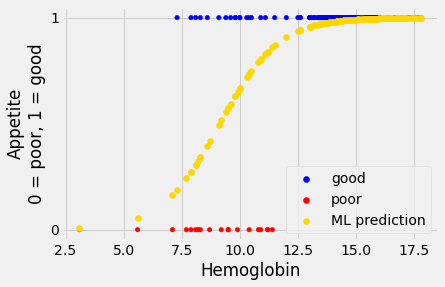

In [23]:
plot_hgb_app()
plt.scatter(hemoglobin, predicted_ML, c='gold', label='ML prediction')
plt.legend();

The ML search by `minimize` is more reliable than the sum-of-squares case
above; it is less dependent on us choosing some reasonable starting values.
This is because the ML cost function is *convex*. Here is the cost-function
curve for the ML cost function, as we vary the intercept for a fixed slope. We
see that we have a much more predictable curve, that slopes smoothly downwards
to a minimum and smoothly upwards after that.

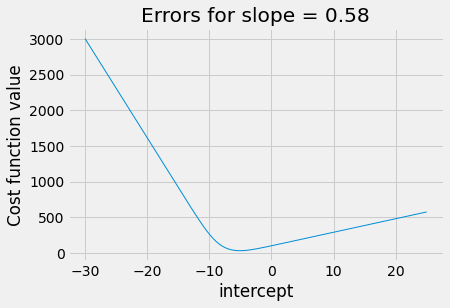

In [24]:
plot_some_intercepts(ml_logit_cost, np.linspace(-30, 25, 1000), slope_ss_logit)

However, this does not mean the ML cost function is infallible.  We can push it to a state where the calculation errors start to overwhelm the values.   However, ML still has the advantage, because, unlike the sum of squares, we do get a warning:

In [25]:
# Starting estimates too far off.
minimize(ml_logit_cost, [6, 3], args=(hemoglobin, appetite_d))

/Users/mb312/Library/Python/3.8/lib/python/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mb312/Library/Python/3.8/lib/python/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: inf
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([nan, nan])
  message: 'NaN result encountered.'
     nfev: 3
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([6., 3.])

## Another example

You will find another demonstration of this difference between sum of squares
and maximum likelihood in [this on logistic cost functions](logistic_flails).